In this colab there are 4 steps:
  - **feature extraction** from corpus
  - definition of **Perceptron** and **AveragePerceptron** classes
  - fit of both perceptrons and display of results
  - try sklearn implementation of **Perceptron** and **LogisticRegression** on the same corpus to compare results

In [ ]:
#imports
import requests
import re
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron as sklearnPerceptron
from sklearn.linear_model import LogisticRegression


**FEATURES EXTRACTION**

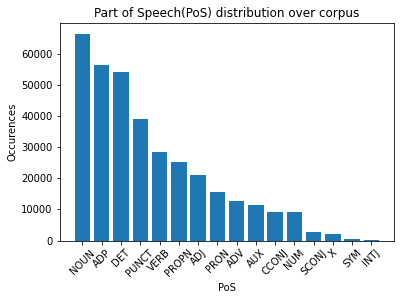

In [ ]:
def extract_examples_from_corpus(path):
    final_list = []
    lines = requests.get(path).text.strip().split("\n")
    #clean data
    text = "\n".join([line for line in lines if not re.match("(#.*)|(\d+-\d+)", line)])
    for sentence in text.split("\n\n"):
        word_sequence = []
        pos_sequence = []
        for line in sentence.split("\n"):
            line = line.split("\t")
            #get word and PoS
            word_sequence.append(line[1])
            pos_sequence.append(line[3])
        final_list.append((word_sequence, pos_sequence))
    return final_list

def plot_distribution(examples_list):
    labels_distrib = {}
    for example in examples_list:
        for label in example[1]:
            labels_distrib[label] = labels_distrib.setdefault(label, 0)+1
    #build parallel arrays
    labels = np.array(sorted(labels_distrib.items(), key=lambda x: x[1], reverse=True))
    plt.bar(labels[:, 0], labels[:, 1].astype(np.int32))
    plt.xticks(rotation=45)
    plt.xlabel("PoS")
    plt.ylabel("Occurences")
    plt.title("Part of Speech(PoS) distribution over corpus")
    plt.show()

def compute_TfIdf(examples_list):
    tf_dictionnary = {}
    idf_dictionnary = {}
    tf_idf_dictionnary = {}
    for sentence, labels in examples_list:
        for word in sentence:
            tf_dictionnary[word] = tf_dictionnary.setdefault(word, 0) +1
        for word in set(sentence):
            idf_dictionnary[word] = idf_dictionnary.setdefault(word, 0) +1

    for (key, value) in tf_dictionnary.items():
            tf_idf_dictionnary[key] = value*(math.log(len(examples_list)/idf_dictionnary.get(key), 10))
    tf_idf_dictionnary[""] = 0.0
    return tf_idf_dictionnary


def extract_features(examples_list, tfidf_dictionnary):
    pairs = []
    for sentence, labels in examples_list:
        for index, (word, label) in enumerate(zip(sentence, labels)):
            features = [tfidf_dictionnary.get(word, 0.0),
                        tfidf_dictionnary.get(get_word_at(sentence, index-1), 0.0),
                        tfidf_dictionnary.get(get_word_at(sentence, index-2), 0.0),
                        tfidf_dictionnary.get(get_word_at(sentence, index+1), 0.0),
                        tfidf_dictionnary.get(get_word_at(sentence, index+2), 0.0),
                        float(re.match("[A-Z].*", word) is not None),
                        float(re.match(".*\d.*", word) is not None)]
            pairs.append((features, label))
    return pairs


def get_word_at(sentence, n):
    try:
        return sentence[n]
    except IndexError:
        return ""


train_data = extract_examples_from_corpus(path = "https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-train.conllu")
test_data = extract_examples_from_corpus(path = "https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-test.conllu")

tfidf_dictionnary = compute_TfIdf(train_data)
plot_distribution(train_data)
train_data = extract_features(train_data, tfidf_dictionnary)
test_data = extract_features(test_data, tfidf_dictionnary)
labels = {tup[1] for tup in train_data}

**PERCEPTRON**

In [ ]:
class Perceptron:
    dimensions = int()
    weights = dict()

    def __init__(self, labels):
        self.dimensions = 7
        self.weights = {label: {dim: float(random.randrange(1000, 10000)) for dim in range(self.dimensions)} for label in labels}

    def fit(self, train_corpus, test_corpus, max_iter):
        logging_step = max_iter // 100 + 1
        test_scores_list = []
        for iter in range(0, max_iter + 1):
            random_observation = train_corpus[np.random.randint(0, len(train_corpus))]
            self.update_single_example(random_observation)
            if iter % logging_step == 0:
                test_scores_list.append(self.score(test_corpus))
        self.plot_results(test_scores_list, max_iter, logging_step)

    def dot(self, observation, parameters):
        total = 0
        for index, obs in enumerate(observation):
            total += obs * parameters.get(index)
        return total

    def score(self, corpus):
        return sum([self.predict(observation) == tag for observation, tag in corpus]) / len(corpus)

    def predict(self, observation):
        label_confidences = {label: self.dot(observation, value) for label, value in self.weights.items()}
        result = max(label_confidences.items(), key=lambda x: x[1])
        return result[0]

    def update_single_example(self, observation):
        pred = self.predict(observation[0])
        if pred != observation[1]:
            for index, value in enumerate(observation[0]):
                self.weights[pred][index] = self.weights[pred][index] - math.fabs(value)
                self.weights[observation[1]][index] = self.weights[observation[1]][index] + math.fabs(value)

    def plot_results(self, data, max_iter, logging_step):
        x = np.arange(logging_step, max_iter + logging_step, logging_step)
        plt.ylim(0.0, 0.5)
        plt.plot(x, data)
        plt.xlabel("iteration number")
        plt.ylabel("accuracy (%)")
        plt.suptitle("accuracy according to number of iterations from Perceptron")
        plt.title("(on test set)")
        plt.show()
        print(f"Accuracy score on test corpus at iteration {max_iter}: {data[-1]}")


**AVERAGED PERCEPTRON**

In [ ]:
class AveragedPerceptron(Perceptron):

    def __init__(self, labels):
        super().__init__(labels)
        self.averaged_weights = {label : {feature : value for feature, value in weight.items()} for label, weight in self.weights.items()}

    def fit(self, train_corpus, test_corpus, max_iter):
        logging_step = max_iter // 100 + 1
        test_scores_list = []
        for iter in range(0, max_iter + 1):
            random_observation = train_corpus[np.random.randint(0, len(train_corpus))]
            self.update_single_example(random_observation)
            self.update_averaged_weights()
            if iter % logging_step == 0:
                test_scores_list.append(self.score(test_corpus))
        self.plot_results(test_scores_list, max_iter, logging_step)

    def update_averaged_weights(self):
        for label, weights in self.averaged_weights.items():
            for feature, value in weights.items():
                self.averaged_weights[label][feature] = value + self.weights[label][feature]

    def score(self, corpus):
        predictions = []
        for observation, tag in corpus:
            label_confidences = {label: self.dot(observation, value) for label, value in self.averaged_weights.items()}
            predictions.append(max(label_confidences.items(), key=lambda x: x[1])[0])
        return sum([pred == tag for pred, (_, tag) in zip(predictions, corpus)]) / len(corpus)

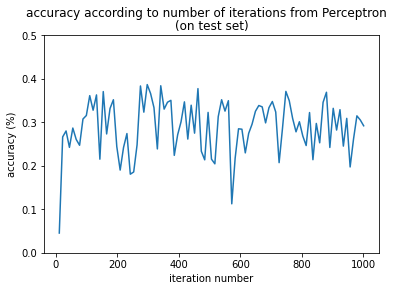

Accuracy score on test corpus at iteration 1000: 0.2920619071392911


In [ ]:
#try vanilla perceptron and averaged perceptron
perceptron = Perceptron(labels)
perceptron.fit(train_data, test_data, 1_000)

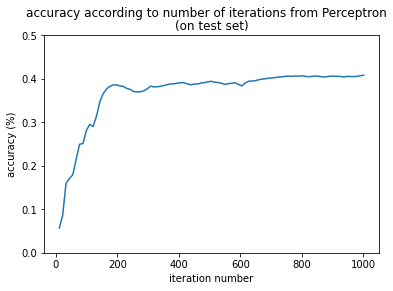

Accuracy score on test corpus at iteration 1000: 0.40838741887169244


In [ ]:
perceptron = AveragedPerceptron(labels)
perceptron.fit(train_data, test_data, 1_000)

**sklearn Perceptron and LogisticRegression**

In [ ]:
#try sklearn implementation

X_train = []
y_train = []
for words, labels in train_data:
    X_train.append(words)
    y_train.append(labels)
X_test = []
y_test = []
for words, labels in test_data:
    X_test.append(words)
    y_test.append(labels)

perceptron = sklearnPerceptron(max_iter= 100_000)
perceptron.fit(X_train, y_train)
pred = perceptron.predict(X_test)
print(sum([y_test[index] == pred[index] for index in range(len(y_test))]) / len(y_test))

regressor = LogisticRegression()
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
print(sum([y_test[index] == pred[index] for index in range(len(y_test))]) / len(y_test))


0.20059910134797804
0.43155267099350975


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
